In [ ]:
#!pip install scikeras[tensorflow]

In [1]:
%load_ext tensorboard

#Python Packages
from typing import Tuple, List, Dict

#Basic Packages
import math
import numpy as np
import datetime


# Machine Learning Packages
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
from keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard

# Hypertunning
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
# import scikeras



# Load the TensorBoard notebook extension.
import tensorboard


# ploting packages
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

In [21]:
def load_data(name: str = "mnist", scale: bool = False, one_hot: bool = False) -> Tuple[
            np.ndarray, np.ndarray, np.ndarray, np.ndarray]:

    # Download Dataset
    if name == "mnist":
        (X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()
        
    elif name == "cifar10":
        (X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

    classes = np.unique(y_train)
    num_classes = classes.shape[0]   
    if scale:
        # Scale images to the [0, 1] range
        X_train = X_train.astype("float32") / 255
        X_test = X_test.astype("float32") / 255

    if one_hot:
        # Create one-hot-encoding 
        y_train = to_categorical(y_train, num_classes=num_classes)
        y_test = to_categorical(y_test, num_classes=num_classes)

    return X_train, y_train, X_test, y_test, classes

def plot(imgs: np.ndarray, labels: np.ndarray, num_col: int) -> go.Figure:
    n = math.ceil(imgs.shape[0]/num_col)
    fig = make_subplots(rows=n, cols=num_col,
                        shared_xaxes= True,
                        # shared_yaxes=True,
                        vertical_spacing=0.06,
                        horizontal_spacing=0.01,
                        subplot_titles= [str(l) for l in labels])
    for i, img in enumerate(imgs):
        fig.add_trace(px.imshow(img).data[0], i//num_col+1, i%num_col+1,)

    # the layout gets lost, so we have to carry it over - so we remake them
    layout = px.imshow(imgs[0],
                       color_continuous_scale='gray').layout

    fig.layout.coloraxis = layout.coloraxis
    fig.update_layout(showlegend=True)
    return fig

def plot_keras_history(hist, only_acc: bool= False) -> go.Figure:
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    if only_acc:
        for key in ["accuracy", "val_accuracy"]:
            fig.add_trace(go.Scatter(x=list(range(hist.params["epochs"])), y=hist.history[key], name=key, mode='lines'))

    else:
        for key in hist.history.keys():
            fig.add_trace(go.Scatter(x=list(range(hist.params["epochs"])), y=hist.history[key], name=key, mode='lines'))

    return fig

def train(model: keras.Sequential, dataset_name: str = "cifar10",
          batch_size: int = 32, epochs: int = 25, learning_rate: float=1e-3,
          optimizer= keras.optimizers.Adam):
    
    X_train, y_train , X_test, y_test, classes = load_data(name= dataset_name, scale= True, one_hot= True)

    # Define the Keras TensorBoard callback.
    logdir = f'logs/fit/{dataset_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, write_graph=True)

    opt = optimizer(learning_rate= learning_rate)

    model.compile(loss='categorical_crossentropy',
                optimizer=opt, metrics=["accuracy",'Precision', 'Recall'])
    model.build()
    hist = model.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.1,
            callbacks=[tensorboard_callback])
    
    score = model.evaluate(X_test, y_test, verbose=0)
    print("Test loss:", score[0])   
    print("Test accuracy:", score[1])

    plot_keras_history(hist).show()

def plot_sklearn_history(hist: dict) -> go.Figure:
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    for key in hist.keys():
        fig.add_trace(go.Scatter(x=list(range(hist["epochs"])), y=hist[key], name=key, mode='lines'))

    return fig

def hypertunning_model(build_model: keras.Sequential, params: dict,
                       dataset_name: str = "cifar10", epochs: int= 25):
  
    def get_model(loss, optimizer, learning_rate):
        model = build_model.build()
        opt = optimizer(learning_rate= learning_rate)
        model.compile(loss=loss, optimizer=opt, metrics=["accuracy",'Precision', 'Recall'])

        return model

    X_train, y_train , X_test, y_test, classes = load_data(name= dataset_name, scale= True, one_hot= False)
    y_train= y_train.reshape(y_train.shape[0])
    y_test= y_test.reshape(y_test.shape[0])
    # Compile model
    
    model = KerasClassifier(build_fn= get_model, verbose=0, epochs= epochs)

    gs = GridSearchCV(model, params, refit=True, cv=2, scoring='accuracy')

    gs.fit(X_train, y_train)
    print()
    print(f"best score: {gs.best_score_} \n its parameters: {gs.best_params_}")
    print()
    # plot_history(gs.cv_results_, only_acc=False).show()
    y_pred = gs.predict(X_test)
    print(classification_report(y_test.tolist(), y_pred.tolist(), labels=classes.tolist()))

    return gs



# Question 1)

In [3]:
X_train, y_train , X_test, y_test, classes = load_data(name= "mnist", scale= True, one_hot= False)
plot(imgs = np.array([np.rot90(img.T) for img in X_train[:20]]), labels= y_train[:20], num_col=5)

11490434/11490434 [==============================] - 0s 0us/step


##A regular CNN

As shown with details in the 2nd question I used the hyperparameters below:

Optimizer= Adam

batch_size = [8, 16, 32, 64, 128]

epochs = 25

learning_rate=[0.1, 0.01, 1e-3, 1e-4]

Since changing the number of epochs could be monitored by looking at the plot at that the end I used the plot.

The learning rate <= 0.01 were not good because the model changed a lot and did not yeld good results, learning rate 1e-3 and 1e-4 were good.

With small batch_sizes the model overfits faster without getting a good accuracy, my guess is that it's because the number of updates are more.

In the most training 20 epochs was where it started to overfit so I stop at 20

For SGD, higher learning_rate actually better for accuracy of training and validation and more epochs were benifitial so this is the hyperparameters for SGD:

batch_size= 128, epochs= 20, learning_rate=1e-1, 




In [20]:
class CNN():
    @staticmethod
    def build(width=28, height=28, depth=1, num_classes=10,) -> keras.Sequential:
        model = keras.Sequential(
            [
                keras.Input(shape=(width, height, depth)),
                layers.Conv2D(filters=8, kernel_size=(3,3), strides=1, padding="same",
                                activation='relu'),
                layers.Conv2D(filters=8, kernel_size=(3,3), strides=1, padding="same",
                                activation='relu'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=2),
                layers.Conv2D(filters=16, kernel_size=(3,3), strides=2, padding="same",
                                activation='relu'),
                layers.Conv2D(filters=16, kernel_size=(3,3), strides=1, padding="same",
                                activation='relu'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=1),
                layers.Flatten(),
                # layers.Dropout(0.5),
                layers.Dense(num_classes, activation="softmax"),
            ]
        )

        return model

CNN.build().summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 conv2d_64 (Conv2D)          (None, 28, 28, 8)         584       
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 14, 14, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 7, 7, 16)          1168      
                                                                 
 conv2d_66 (Conv2D)          (None, 7, 7, 16)          2320      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 6, 6, 16)         0         
 g2D)                                                

In [ ]:
# Define the Keras TensorBoard callback.
logdir = "logs/fit/q1_1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, write_graph=True)

train(model= CNN.build(), dataset_name= "mnist",
          batch_size= 128, epochs= 20, learning_rate=1e-3,)

# %load_ext tensorboard
# %tensorboard --logdir logs

Epoch 1/20
422/422 [==============================] - 4s 8ms/step - loss: 0.4027 - accuracy: 0.8787 - precision: 0.9447 - recall: 0.8258 - val_loss: 0.1025 - val_accuracy: 0.9700 - val_precision: 0.9767 - val_recall: 0.9643
Epoch 2/20
422/422 [==============================] - 3s 7ms/step - loss: 0.1045 - accuracy: 0.9683 - precision: 0.9734 - recall: 0.9639 - val_loss: 0.0691 - val_accuracy: 0.9803 - val_precision: 0.9845 - val_recall: 0.9768
Epoch 3/20
422/422 [==============================] - 3s 7ms/step - loss: 0.0789 - accuracy: 0.9759 - precision: 0.9793 - recall: 0.9730 - val_loss: 0.0619 - val_accuracy: 0.9827 - val_precision: 0.9848 - val_recall: 0.9820
Epoch 4/20
422/422 [==============================] - 3s 7ms/step - loss: 0.0624 - accuracy: 0.9807 - precision: 0.9833 - recall: 0.9789 - val_loss: 0.0596 - val_accuracy: 0.9840 - val_precision: 0.9853 - val_recall: 0.9815
Epoch 5/20
422/422 [==============================] - 3s 7ms/step - loss: 0.0529 - accuracy: 0.9837 - pr

In [ ]:
# Define the Keras TensorBoard callback.
logdir = "logs/fit/q1_1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, write_graph=True)

train(model= CNN.build(), dataset_name= "mnist",
          batch_size= 128, epochs= 25, learning_rate=1e-3,
          optimizer= keras.optimizers.RMSprop        
        )

# %load_ext tensorboard
# %tensorboard --logdir logs

Epoch 1/25
422/422 [==============================] - 5s 8ms/step - loss: 0.4011 - accuracy: 0.8757 - precision: 0.9342 - recall: 0.8269 - val_loss: 0.1349 - val_accuracy: 0.9587 - val_precision: 0.9689 - val_recall: 0.9510
Epoch 2/25
422/422 [==============================] - 3s 7ms/step - loss: 0.1200 - accuracy: 0.9621 - precision: 0.9680 - recall: 0.9576 - val_loss: 0.0744 - val_accuracy: 0.9787 - val_precision: 0.9824 - val_recall: 0.9757
Epoch 3/25
422/422 [==============================] - 3s 7ms/step - loss: 0.0854 - accuracy: 0.9736 - precision: 0.9770 - recall: 0.9709 - val_loss: 0.0802 - val_accuracy: 0.9780 - val_precision: 0.9811 - val_recall: 0.9755
Epoch 4/25
422/422 [==============================] - 3s 7ms/step - loss: 0.0678 - accuracy: 0.9784 - precision: 0.9813 - recall: 0.9760 - val_loss: 0.0591 - val_accuracy: 0.9845 - val_precision: 0.9860 - val_recall: 0.9825
Epoch 5/25
422/422 [==============================] - 3s 7ms/step - loss: 0.0575 - accuracy: 0.9818 - pr

## general hypertuning 
This is a grid search hypertuning on all the params:

In [30]:
params = {
          "loss" : ['categorical_crossentropy'],
          "optimizer": [keras.optimizers.Adam, keras.optimizers.SGD, keras.optimizers.RMSprop],
          'batch_size':[128, 64,],
          "learning_rate": [1e-4, 1e-3]
}
# I also limted the number of params extensively since it would have taken alot of time;
# Right now, it's training 24 (2(cv)*1(loss)*3(opt)*2(bs)*2(lr)) models for 10 epochs but the initial search space was 240

gs = hypertunning_model(build_model= CNN, params= params,
                       dataset_name= "mnist", epochs= 10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: DeprecationWarning:

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



938/938 [==============================] - 2s 2ms/step

best score: 0.9812666666666667 
 its parameters: {'batch_size': 64, 'learning_rate': 0.001, 'loss': 'categorical_crossentropy', 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>}

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.98      1.00      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.98      1.00      0.99       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       1.00      0.96      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0

All the above would work for all the parts fpr above and below but to avoid making the notebook big and wasting time, some functions where not used for the rest of examples.

## An inverted CNN

As shown with details in the 2nd question I used the hyperparameters below:

batch_size = [8, 16, 32, 64, 128]

epochs = 30

learning_rate=[0.1, 0.01, 1e-3, 1e-4]

Since changing the number of epochs could be monitored by looking at the plot at that the end I used the plot.

The learning rate <= 0.01 were not good because the model changed a lot and did not yeld good results, learning rate 1e-3 and 1e-4 were good but because I was also using weight decay I decided to use 1e-3

With small batch_sizes the model overfits faster without getting a good accuracy, my guess is that it's because the number of updates are more.

The Model seemed less prone to overfiting so I used more epochs which helped the end results.

batch_size= 128, epochs= 30, learning_rate=1e-3



In [9]:
class Inverted_CNN():
    @staticmethod
    def build(width=28, height=28, depth=1, num_classes=10,) -> keras.Sequential:
        model = keras.Sequential(
            [
                keras.Input(shape=(width, height, depth)),
                layers.Conv2D(filters=16, kernel_size=(3,3), strides=1, padding="same",
                                activation='relu'),
                layers.Conv2D(filters=16, kernel_size=(3,3), strides=1, padding="same",
                                activation='relu'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=2),
                layers.Conv2D(filters=8, kernel_size=(3,3), strides=2, padding="same",
                                activation='relu'),
                layers.Conv2D(filters=8, kernel_size=(3,3), strides=1, padding="same",
                                activation='relu'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=1),
                layers.Flatten(),
                layers.Dropout(0.5),
                layers.Dense(num_classes, activation="softmax"),
            ]
        )

        return model

Inverted_CNN.build().summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_204 (Conv2D)         (None, 28, 28, 16)        160       
                                                                 
 conv2d_205 (Conv2D)         (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d_102 (MaxPooli  (None, 14, 14, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_206 (Conv2D)         (None, 7, 7, 8)           1160      
                                                                 
 conv2d_207 (Conv2D)         (None, 7, 7, 8)           584       
                                                                 
 max_pooling2d_103 (MaxPooli  (None, 6, 6, 8)          0         
 ng2D)                                               

In [13]:
# Define the Keras TensorBoard callback.
logdir = "logs/fit/q1_2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, write_graph=True)

train(model= Inverted_CNN.build(), dataset_name= "mnist",
          batch_size= 128, epochs= 30, learning_rate=1e-3)

# %load_ext tensorboard
# %tensorboard --logdir logs

Epoch 1/30
422/422 [==============================] - 8s 15ms/step - loss: 0.6923 - accuracy: 0.7662 - precision: 0.8971 - recall: 0.6925 - val_loss: 0.1225 - val_accuracy: 0.9630 - val_precision: 0.9719 - val_recall: 0.9557
Epoch 2/30
422/422 [==============================] - 6s 13ms/step - loss: 0.2121 - accuracy: 0.9343 - precision: 0.9474 - recall: 0.9228 - val_loss: 0.0830 - val_accuracy: 0.9762 - val_precision: 0.9816 - val_recall: 0.9705
Epoch 3/30
422/422 [==============================] - 4s 9ms/step - loss: 0.1582 - accuracy: 0.9514 - precision: 0.9598 - recall: 0.9439 - val_loss: 0.0713 - val_accuracy: 0.9795 - val_precision: 0.9834 - val_recall: 0.9758
Epoch 4/30
422/422 [==============================] - 3s 7ms/step - loss: 0.1374 - accuracy: 0.9570 - precision: 0.9640 - recall: 0.9508 - val_loss: 0.0662 - val_accuracy: 0.9822 - val_precision: 0.9854 - val_recall: 0.9798
Epoch 5/30
422/422 [==============================] - 3s 7ms/step - loss: 0.1215 - accuracy: 0.9627 - 

In [31]:
params = {
          "loss" : ['categorical_crossentropy'],
          "optimizer": [keras.optimizers.Adam, keras.optimizers.SGD, keras.optimizers.RMSprop],
          'batch_size':[128, 64,],
          "learning_rate": [1e-2, 1e-3]
}
# I also limted the number of params extensively since it would have taken alot of time;
# Right now, it's training 24 (2(cv)*1(loss)*3(opt)*2(bs)*2(lr)) models for 10 epochs but the initial search space was 240

gs = hypertunning_model(build_model= CNN, params= params,
                       dataset_name= "mnist", epochs= 10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: DeprecationWarning:

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



938/938 [==============================] - 2s 2ms/step

best score: 0.9842 
 its parameters: {'batch_size': 64, 'learning_rate': 0.001, 'loss': 'categorical_crossentropy', 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>}

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.98      0.99      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.97      0.98       974
           9       0.98      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weig

## An hour-glass shaped CNN

As shown with details in the 2nd question I used the hyperparameters below:

batch_size = [8, 16, 32, 64, 128]

epochs = 30

learning_rate=[0.1, 0.01, 1e-3, 1e-4]

Since changing the number of epochs could be monitored by looking at the plot at that the end I used the plot.

The learning rate <= 0.01 were not good because the model changed a lot and did not yeld good results, learning rate 1e-3 and 1e-4 were good but because 1e-3 was better but it seemed that there was a a threshold that the model couldn't break on loss: 0.05

With small batch_sizes the model overfits faster without getting a good accuracy, my guess is that it's because the number of updates are more.

The Model seemed loss prone to overfiting so I used more epochs which helped the end results.

In [2]:
class Hour_Glass_CNN():
    @staticmethod
    def build(width=28, height=28, depth=1, num_classes=10,) -> keras.Sequential:
        model = keras.Sequential(
            [
                keras.Input(shape=(width, height, depth)),
                layers.Conv2D(filters=16, kernel_size=(3,3), strides=1, padding="same",
                                activation='relu'),
                layers.Conv2D(filters=16, kernel_size=(3,3), strides=1, padding="same",
                                activation='relu'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=2),
                layers.Conv2D(filters=8, kernel_size=(3,3), strides=2, padding="same",
                                activation='relu'),
                layers.Conv2D(filters=8, kernel_size=(3,3), strides=1, padding="same",
                                activation='relu'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=1),
                layers.Conv2D(filters=16, kernel_size=(3,3), strides=2, padding="same",
                                activation='relu'),
                layers.Conv2D(filters=16, kernel_size=(3,3), strides=1, padding="same",
                                activation='relu'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=1),
                layers.Flatten(),
                layers.Dropout(0.5),
                layers.Dense(num_classes, activation="softmax"),
            ]
        )

        return model

Hour_Glass_CNN.build().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 8)           584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 8)          0         
 2D)                                                    

In [34]:
# Define the Keras TensorBoard callback.
logdir = "logs/fit/q1_3/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, write_graph=True)

train(model= Hour_Glass_CNN.build(), dataset_name= "mnist",
          batch_size= 64, epochs= 30, learning_rate=1e-3)

# %load_ext tensorboard
# %tensorboard --logdir logs

Epoch 1/30
844/844 [==============================] - 7s 7ms/step - loss: 0.6857 - accuracy: 0.7760 - precision: 0.9037 - recall: 0.7007 - val_loss: 0.1433 - val_accuracy: 0.9580 - val_precision: 0.9661 - val_recall: 0.9498
Epoch 2/30
844/844 [==============================] - 6s 7ms/step - loss: 0.2293 - accuracy: 0.9344 - precision: 0.9519 - recall: 0.9175 - val_loss: 0.0911 - val_accuracy: 0.9765 - val_precision: 0.9821 - val_recall: 0.9712
Epoch 3/30
844/844 [==============================] - 6s 7ms/step - loss: 0.1712 - accuracy: 0.9521 - precision: 0.9648 - recall: 0.9403 - val_loss: 0.0926 - val_accuracy: 0.9745 - val_precision: 0.9804 - val_recall: 0.9685
Epoch 4/30
844/844 [==============================] - 6s 7ms/step - loss: 0.1424 - accuracy: 0.9600 - precision: 0.9702 - recall: 0.9503 - val_loss: 0.0750 - val_accuracy: 0.9802 - val_precision: 0.9844 - val_recall: 0.9783
Epoch 5/30
844/844 [==============================] - 6s 7ms/step - loss: 0.1265 - accuracy: 0.9640 - pr

In [33]:
params = {
          "loss" : ['categorical_crossentropy'],
          "optimizer": [keras.optimizers.Adam, keras.optimizers.SGD, keras.optimizers.RMSprop],
          'batch_size':[128, 64,],
          "learning_rate": [1e-2, 1e-3, 1e-4]
}
# I also limted the number of params extensively since it would have taken alot of time;
# Right now, it's training 24 (2(cv)*1(loss)*3(opt)*2(bs)*2(lr)) models for 10 epochs but the initial search space was 240

gs = hypertunning_model(build_model= Hour_Glass_CNN, params= params,
                       dataset_name= "mnist", epochs= 10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: DeprecationWarning:

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



938/938 [==============================] - 2s 2ms/step

best score: 0.9757166666666667 
 its parameters: {'batch_size': 64, 'learning_rate': 0.001, 'loss': 'categorical_crossentropy', 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>}

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.97      1.00      0.98      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.97      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99   

# Question 2)



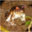
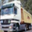
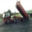
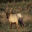
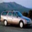
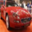
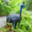
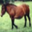
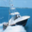
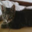
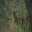
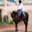
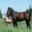
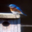
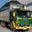
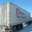
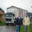
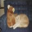
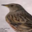
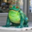

In [15]:
X_train, y_train , X_test, y_test, classes = load_data(name= "cifar10", scale= False, one_hot= False)
plot(imgs = X_train[:20], labels= y_train[:20], num_col=5)

In [8]:
class LeNet():
    @staticmethod
    def build(width=32, height=32, depth=3, num_classes=10,) -> keras.Sequential:
        model = keras.Sequential(
            [
                keras.Input(shape=(width, height, depth)),
                layers.Conv2D(filters=6, kernel_size=(5,5), strides=1, padding="same",
                                activation='relu'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=2),
                layers.Conv2D(filters=16, kernel_size=(5,5), strides=1, padding="same",
                                activation='relu'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=2),
                layers.Conv2D(filters=120, kernel_size=(5,5), strides=1, padding="same",
                                activation='relu'),
                # layers.Flatten(),
                layers.Dense(84, activation='relu'),
                layers.Flatten(),
                # # layers.Dropout(0.5),
                layers.Dense(num_classes, activation="softmax"),
            ]
        )

        return model

class FFN():
    @staticmethod
    def build(width=32, height=32, depth=3, num_classes=10,) -> keras.Sequential:
        model = keras.Sequential(
            [
                keras.Input(shape=(width, height, depth)),
                layers.Dense(units=6, activation='relu'),
                layers.Dense(units=16, activation='relu'),
                layers.Dense(units=120, activation='relu'),
                layers.Dense(units=84, activation='relu'),
                layers.Flatten(),
                layers.Dense(num_classes, activation="softmax"),
            ]
        )

        return model

LeNet.build().summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 32, 32, 6)         456       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 16, 16, 16)        2416      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 8, 8, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 8, 8, 120)         48120     
                                                                 
 dense_5 (Dense)             (None, 8, 8, 84)         

In [16]:
train(model= LeNet.build(), dataset_name= "cifar10",
          batch_size= 64, epochs= 25, learning_rate=1e-4)

Epoch 1/25
704/704 [==============================] - 7s 8ms/step - loss: 1.8280 - accuracy: 0.3409 - precision: 0.6569 - recall: 0.0604 - val_loss: 1.6291 - val_accuracy: 0.4054 - val_precision: 0.6401 - val_recall: 0.1142
Epoch 2/25
704/704 [==============================] - 5s 7ms/step - loss: 1.5613 - accuracy: 0.4428 - precision: 0.6722 - recall: 0.1592 - val_loss: 1.5098 - val_accuracy: 0.4562 - val_precision: 0.6839 - val_recall: 0.1692
Epoch 3/25
704/704 [==============================] - 5s 7ms/step - loss: 1.4766 - accuracy: 0.4746 - precision: 0.6940 - recall: 0.2093 - val_loss: 1.4341 - val_accuracy: 0.4908 - val_precision: 0.7061 - val_recall: 0.2186
Epoch 4/25
704/704 [==============================] - 5s 8ms/step - loss: 1.4185 - accuracy: 0.4974 - precision: 0.7114 - recall: 0.2467 - val_loss: 1.3950 - val_accuracy: 0.5010 - val_precision: 0.7098 - val_recall: 0.2740
Epoch 5/25
704/704 [==============================] - 5s 7ms/step - loss: 1.3727 - accuracy: 0.5151 - pr

1. What is the effect of learning rate on the training process? Which performed best?

Based on the result below the best learning rate is 1e-4 since the model doesn't overfit or underfit on both val and training

In [ ]:
X_train, y_train , X_test, y_test, classes = load_data(name= "cifar10", scale= True, one_hot= True)

# Define the Keras TensorBoard callback.
logdir = "logs/fit/q2_1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, write_graph=True)



batch_size = 64
epochs = 25
learning_rate=[0.1, 0.01, 1e-3, 1e-4]

for i in range(4):
    print(f"Training with learning rate = {learning_rate[i]}")
    train(model= LeNet.build(), dataset_name= "cifar10",
          batch_size= batch_size, epochs= epochs, learning_rate=learning_rate[i])

# %load_ext tensorboard
# %tensorboard --logdir logs

Training with learning rate = 0.1
Epoch 1/25
704/704 [==============================] - 7s 9ms/step - loss: 3.0901 - accuracy: 0.1032 - precision: 0.0859 - recall: 2.4444e-04 - val_loss: 2.3264 - val_accuracy: 0.0976 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
704/704 [==============================] - 5s 7ms/step - loss: 2.3120 - accuracy: 0.0984 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3042 - val_accuracy: 0.1058 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
704/704 [==============================] - 5s 8ms/step - loss: 2.3111 - accuracy: 0.1006 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3097 - val_accuracy: 0.1064 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
704/704 [==============================] - 5s 7ms/step - loss: 2.3117 - accuracy: 0.0998 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3104 - val_accuracy: 0.0958 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25

Training with learning rate = 0.01
Epoch 1/25
704/704 [==============================] - 7s 8ms/step - loss: 1.9197 - accuracy: 0.3026 - precision: 0.5638 - recall: 0.0549 - val_loss: 1.8332 - val_accuracy: 0.3280 - val_precision: 0.5384 - val_recall: 0.0856
Epoch 2/25
704/704 [==============================] - 5s 8ms/step - loss: 1.7172 - accuracy: 0.3787 - precision: 0.5988 - recall: 0.1196 - val_loss: 1.6330 - val_accuracy: 0.3864 - val_precision: 0.6109 - val_recall: 0.1328
Epoch 3/25
704/704 [==============================] - 6s 8ms/step - loss: 1.6545 - accuracy: 0.3970 - precision: 0.6156 - recall: 0.1519 - val_loss: 1.6399 - val_accuracy: 0.4030 - val_precision: 0.5883 - val_recall: 0.1866
Epoch 4/25
704/704 [==============================] - 5s 7ms/step - loss: 1.6268 - accuracy: 0.4074 - precision: 0.6113 - recall: 0.1685 - val_loss: 1.6462 - val_accuracy: 0.3962 - val_precision: 0.5879 - val_recall: 0.1932
Epoch 5/25
704/704 [==============================] - 5s 7ms/step - l

Training with learning rate = 0.001
Epoch 1/25
704/704 [==============================] - 7s 8ms/step - loss: 1.5690 - accuracy: 0.4338 - precision: 0.6719 - recall: 0.1894 - val_loss: 1.2513 - val_accuracy: 0.5492 - val_precision: 0.7123 - val_recall: 0.3620
Epoch 2/25
704/704 [==============================] - 5s 7ms/step - loss: 1.2090 - accuracy: 0.5716 - precision: 0.7338 - recall: 0.3974 - val_loss: 1.0901 - val_accuracy: 0.6152 - val_precision: 0.7640 - val_recall: 0.4564
Epoch 3/25
704/704 [==============================] - 5s 8ms/step - loss: 1.0381 - accuracy: 0.6336 - precision: 0.7705 - recall: 0.4973 - val_loss: 1.0276 - val_accuracy: 0.6494 - val_precision: 0.7517 - val_recall: 0.5492
Epoch 4/25
704/704 [==============================] - 5s 7ms/step - loss: 0.9207 - accuracy: 0.6767 - precision: 0.7914 - recall: 0.5636 - val_loss: 0.9545 - val_accuracy: 0.6702 - val_precision: 0.7723 - val_recall: 0.5616
Epoch 5/25
704/704 [==============================] - 5s 7ms/step - 

Training with learning rate = 0.0001
Epoch 1/25
704/704 [==============================] - 7s 8ms/step - loss: 1.8894 - accuracy: 0.3148 - precision: 0.6653 - recall: 0.0392 - val_loss: 1.6753 - val_accuracy: 0.3932 - val_precision: 0.6450 - val_recall: 0.0894
Epoch 2/25
704/704 [==============================] - 5s 7ms/step - loss: 1.6058 - accuracy: 0.4277 - precision: 0.6681 - recall: 0.1440 - val_loss: 1.5509 - val_accuracy: 0.4484 - val_precision: 0.6689 - val_recall: 0.1596
Epoch 3/25
704/704 [==============================] - 5s 8ms/step - loss: 1.5098 - accuracy: 0.4627 - precision: 0.6883 - recall: 0.1993 - val_loss: 1.4707 - val_accuracy: 0.4688 - val_precision: 0.6799 - val_recall: 0.2188
Epoch 4/25
704/704 [==============================] - 5s 7ms/step - loss: 1.4447 - accuracy: 0.4878 - precision: 0.7007 - recall: 0.2396 - val_loss: 1.4098 - val_accuracy: 0.4960 - val_precision: 0.6941 - val_recall: 0.2550
Epoch 5/25
704/704 [==============================] - 5s 8ms/step -

2. What is the effect of batch size on the training process? Which performed best?

it seems that the model needs more than 25 epoch to train properly thus having a smaller batch_size helps as shown and with higher epochs the model kinda under fits, thus for this trade off it seems that batch_size=32 is the better option although 64 shows a better plot with a fixed epoch; 32 is less likely to be underfit than 64.

In [ ]:
X_train, y_train , X_test, y_test, classes = load_data(name= "cifar10", scale= True, one_hot= True)

# Define the Keras TensorBoard callback.
logdir = "logs/fit/q2_2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, write_graph=True)



batch_size = [8, 16, 32, 64, 128, 256]
epochs = 25
learning_rate= 1e-4

for i in range(6):
    print(f"Training with batch_size = {batch_size [i]}")
    train(model= LeNet.build(), dataset_name= "cifar10",
          batch_size= batch_size[i], epochs= epochs, learning_rate=learning_rate)

# %load_ext tensorboard
# %tensorboard --logdir logs

Training with batch_size = 8
Epoch 1/25
5625/5625 [==============================] - 32s 6ms/step - loss: 1.6867 - accuracy: 0.3907 - precision: 0.6592 - recall: 0.1183 - val_loss: 1.5046 - val_accuracy: 0.4612 - val_precision: 0.6898 - val_recall: 0.1912
Epoch 2/25
5625/5625 [==============================] - 28s 5ms/step - loss: 1.4349 - accuracy: 0.4856 - precision: 0.6966 - recall: 0.2413 - val_loss: 1.3594 - val_accuracy: 0.5070 - val_precision: 0.7025 - val_recall: 0.2810
Epoch 3/25
5625/5625 [==============================] - 28s 5ms/step - loss: 1.3171 - accuracy: 0.5302 - precision: 0.7196 - recall: 0.3158 - val_loss: 1.2860 - val_accuracy: 0.5374 - val_precision: 0.7093 - val_recall: 0.3596
Epoch 4/25
5625/5625 [==============================] - 28s 5ms/step - loss: 1.2238 - accuracy: 0.5667 - precision: 0.7389 - recall: 0.3782 - val_loss: 1.1901 - val_accuracy: 0.5736 - val_precision: 0.7373 - val_recall: 0.3924
Epoch 5/25
5625/5625 [==============================] - 27s 5ms

Training with batch_size = 16
Epoch 1/25
2813/2813 [==============================] - 18s 6ms/step - loss: 1.7298 - accuracy: 0.3808 - precision: 0.6697 - recall: 0.1023 - val_loss: 1.5502 - val_accuracy: 0.4546 - val_precision: 0.6919 - val_recall: 0.1554
Epoch 2/25
2813/2813 [==============================] - 16s 6ms/step - loss: 1.4817 - accuracy: 0.4707 - precision: 0.6919 - recall: 0.2205 - val_loss: 1.4070 - val_accuracy: 0.4988 - val_precision: 0.7171 - val_recall: 0.2590
Epoch 3/25
2813/2813 [==============================] - 16s 6ms/step - loss: 1.3742 - accuracy: 0.5117 - precision: 0.7154 - recall: 0.2844 - val_loss: 1.3259 - val_accuracy: 0.5318 - val_precision: 0.7235 - val_recall: 0.3108
Epoch 4/25
2813/2813 [==============================] - 17s 6ms/step - loss: 1.2869 - accuracy: 0.5484 - precision: 0.7317 - recall: 0.3365 - val_loss: 1.2626 - val_accuracy: 0.5562 - val_precision: 0.7338 - val_recall: 0.3584
Epoch 5/25
2813/2813 [==============================] - 16s 6m

Training with batch_size = 32
Epoch 1/25
1407/1407 [==============================] - 10s 7ms/step - loss: 1.8393 - accuracy: 0.3421 - precision: 0.6500 - recall: 0.0631 - val_loss: 1.6428 - val_accuracy: 0.4048 - val_precision: 0.6291 - val_recall: 0.1228
Epoch 2/25
1407/1407 [==============================] - 9s 6ms/step - loss: 1.5503 - accuracy: 0.4439 - precision: 0.6802 - recall: 0.1742 - val_loss: 1.5012 - val_accuracy: 0.4550 - val_precision: 0.6617 - val_recall: 0.2050
Epoch 3/25
1407/1407 [==============================] - 9s 7ms/step - loss: 1.4357 - accuracy: 0.4875 - precision: 0.7032 - recall: 0.2419 - val_loss: 1.3745 - val_accuracy: 0.5068 - val_precision: 0.6982 - val_recall: 0.2684
Epoch 4/25
1407/1407 [==============================] - 9s 6ms/step - loss: 1.3562 - accuracy: 0.5167 - precision: 0.7181 - recall: 0.2921 - val_loss: 1.3565 - val_accuracy: 0.5048 - val_precision: 0.6899 - val_recall: 0.2914
Epoch 5/25
1407/1407 [==============================] - 9s 6ms/st

Training with batch_size = 64
Epoch 1/25
704/704 [==============================] - 6s 8ms/step - loss: 1.9710 - accuracy: 0.2945 - precision: 0.6743 - recall: 0.0268 - val_loss: 1.7269 - val_accuracy: 0.3958 - val_precision: 0.6331 - val_recall: 0.0918
Epoch 2/25
704/704 [==============================] - 5s 7ms/step - loss: 1.6333 - accuracy: 0.4196 - precision: 0.6703 - recall: 0.1275 - val_loss: 1.5517 - val_accuracy: 0.4504 - val_precision: 0.6634 - val_recall: 0.1624
Epoch 3/25
704/704 [==============================] - 5s 7ms/step - loss: 1.5222 - accuracy: 0.4582 - precision: 0.6852 - recall: 0.1880 - val_loss: 1.4913 - val_accuracy: 0.4672 - val_precision: 0.6717 - val_recall: 0.1956
Epoch 4/25
704/704 [==============================] - 5s 7ms/step - loss: 1.4519 - accuracy: 0.4848 - precision: 0.7021 - recall: 0.2288 - val_loss: 1.4239 - val_accuracy: 0.4908 - val_precision: 0.6869 - val_recall: 0.2470
Epoch 5/25
704/704 [==============================] - 5s 8ms/step - loss: 

Training with batch_size = 128
Epoch 1/25
352/352 [==============================] - 4s 10ms/step - loss: 1.9456 - accuracy: 0.3070 - precision: 0.6372 - recall: 0.0236 - val_loss: 1.7237 - val_accuracy: 0.3768 - val_precision: 0.6267 - val_recall: 0.0648
Epoch 2/25
352/352 [==============================] - 3s 8ms/step - loss: 1.6536 - accuracy: 0.4079 - precision: 0.6632 - recall: 0.1080 - val_loss: 1.5959 - val_accuracy: 0.4278 - val_precision: 0.6701 - val_recall: 0.1186
Epoch 3/25
352/352 [==============================] - 3s 8ms/step - loss: 1.5546 - accuracy: 0.4439 - precision: 0.6808 - recall: 0.1576 - val_loss: 1.5174 - val_accuracy: 0.4498 - val_precision: 0.6871 - val_recall: 0.1656
Epoch 4/25
352/352 [==============================] - 3s 8ms/step - loss: 1.4954 - accuracy: 0.4654 - precision: 0.6926 - recall: 0.1917 - val_loss: 1.4745 - val_accuracy: 0.4708 - val_precision: 0.6791 - val_recall: 0.2044
Epoch 5/25
352/352 [==============================] - 3s 8ms/step - loss

Training with batch_size = 256
Epoch 1/25
176/176 [==============================] - 5s 21ms/step - loss: 2.0895 - accuracy: 0.2433 - precision: 0.6467 - recall: 0.0043 - val_loss: 1.9083 - val_accuracy: 0.3254 - val_precision: 0.5941 - val_recall: 0.0240
Epoch 2/25
176/176 [==============================] - 2s 11ms/step - loss: 1.8199 - accuracy: 0.3547 - precision: 0.6573 - recall: 0.0489 - val_loss: 1.7656 - val_accuracy: 0.3748 - val_precision: 0.6517 - val_recall: 0.0726
Epoch 3/25
176/176 [==============================] - 2s 12ms/step - loss: 1.7088 - accuracy: 0.3965 - precision: 0.6796 - recall: 0.0865 - val_loss: 1.6625 - val_accuracy: 0.4168 - val_precision: 0.6653 - val_recall: 0.0950
Epoch 4/25
176/176 [==============================] - 2s 11ms/step - loss: 1.6279 - accuracy: 0.4230 - precision: 0.6812 - recall: 0.1228 - val_loss: 1.6182 - val_accuracy: 0.4256 - val_precision: 0.6424 - val_recall: 0.1502
Epoch 5/25
176/176 [==============================] - 2s 12ms/step - 

3. Try different hyperparameters to obtain the best accuracy on the test set. What is your
best performance and what were the hyperparameters?

Based on the result we have above this parameters should be the best tested ones.

In [29]:
params = {
          "loss" : ['categorical_crossentropy'],
          "optimizer": [keras.optimizers.Adam],
          'batch_size':[64, 32],
          "learning_rate": [1e-4]
}

hypertunning_model(build_model= LeNet, params= params,
                       dataset_name= "cifar10", epochs= 25)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: DeprecationWarning:

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



782/782 [==============================] - 2s 3ms/step

best score: 0.60816 
 its parameters: {'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'categorical_crossentropy', 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>}

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.68      0.75      0.71      1000
           1       0.74      0.77      0.75      1000
           2       0.55      0.54      0.54      1000
           3       0.47      0.47      0.47      1000
           4       0.66      0.48      0.55      1000
           5       0.55      0.56      0.55      1000
           6       0.64      0.79      0.71      1000
           7       0.76      0.68      0.72      1000
           8       0.78      0.78      0.78      1000
           9       0.71      0.71      0.71      1000

    accuracy                           0.65     10000
   macro avg       0.65      0.65      0.65     10000
we

GridSearchCV(cv=2,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa9d771c550>,
             param_grid={'batch_size': [64, 32], 'learning_rate': [0.0001],
                         'loss': ['categorical_crossentropy'],
                         'optimizer': [<class 'keras.optimizers.optimizer_v2.adam.Adam'>]},
             scoring='accuracy')

4. Implement an equivalent feed forward network for the same task with each hidden layer
containing the same number of neurons as the number of filters in each convolution layer.
Use the ‘Adam’ optimizer to train your network on the CIFAR-10 dataset for a fixed set of
25 epochs. Compare its performance with your LeNet implementation based on the
following questions:
a. What is its performance?
b. How many parameters are there in this network compared to the LeNet
implementation? the questions are all shown below.

Are they worth it? Nope, CNN and LeNet is far better in performance and smaller in size.

In [23]:
LeNet.build().summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_83 (Conv2D)          (None, 32, 32, 6)         456       
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 16, 16, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_84 (Conv2D)          (None, 16, 16, 16)        2416      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 8, 8, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_85 (Conv2D)          (None, 8, 8, 120)         48120     
                                                                 
 dense_32 (Dense)            (None, 8, 8, 84)        

In [24]:
FFN.build().summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 32, 32, 6)         24        
                                                                 
 dense_35 (Dense)            (None, 32, 32, 16)        112       
                                                                 
 dense_36 (Dense)            (None, 32, 32, 120)       2040      
                                                                 
 dense_37 (Dense)            (None, 32, 32, 84)        10164     
                                                                 
 flatten_22 (Flatten)        (None, 86016)             0         
                                                                 
 dense_38 (Dense)            (None, 10)                860170    
                                                                 
Total params: 872,510
Trainable params: 872,510
Non-t

In [25]:
# Define the Keras TensorBoard callback.
logdir = "logs/fit/q2_3/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, write_graph=True)



batch_size = 64
epochs = 25
learning_rate=1e-3

train(model= FFN.build(), dataset_name= "cifar10",
        batch_size= batch_size, epochs= epochs, learning_rate=learning_rate)

# %load_ext tensorboard
# %tensorboard --logdir logs

Epoch 1/25
704/704 [==============================] - 11s 15ms/step - loss: 1.7431 - accuracy: 0.3847 - precision: 0.6660 - recall: 0.1254 - val_loss: 1.5529 - val_accuracy: 0.4504 - val_precision: 0.6728 - val_recall: 0.2032
Epoch 2/25
704/704 [==============================] - 9s 13ms/step - loss: 1.5012 - accuracy: 0.4722 - precision: 0.6937 - recall: 0.2409 - val_loss: 1.4901 - val_accuracy: 0.4806 - val_precision: 0.6880 - val_recall: 0.2726
Epoch 3/25
704/704 [==============================] - 9s 13ms/step - loss: 1.4168 - accuracy: 0.5052 - precision: 0.7056 - recall: 0.2912 - val_loss: 1.4618 - val_accuracy: 0.4908 - val_precision: 0.6905 - val_recall: 0.2940
Epoch 4/25
704/704 [==============================] - 9s 13ms/step - loss: 1.3600 - accuracy: 0.5263 - precision: 0.7147 - recall: 0.3245 - val_loss: 1.4450 - val_accuracy: 0.5046 - val_precision: 0.6851 - val_recall: 0.3016
Epoch 5/25
704/704 [==============================] - 9s 13ms/step - loss: 1.2990 - accuracy: 0.548

# Question 3

In [26]:
X1=np.array([[7,5,0,0,3,2],[6,4,5,1,4,8],[9,0,2,2,5,4],[6,3,4,7,9,8],[5,7,5,6,9,0],[7,9,0,8,2,3]])
print(f"X1=\n{X1}")
kernel1 = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
print(f"kernel1=\n{kernel1}")

X1=
[[7 5 0 0 3 2]
 [6 4 5 1 4 8]
 [9 0 2 2 5 4]
 [6 3 4 7 9 8]
 [5 7 5 6 9 0]
 [7 9 0 8 2 3]]
kernel1=
[[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]


1. What are the dimensions of the input and the kernel (or filter)? (6,6,1) and (3,3,1) 

How many parameters are there in the kernel f? 9 or 10 if we also have a bias

this is with activation function applied

In [27]:
filter = tf.keras.initializers.Constant(
    value=kernel1)

In [28]:
X = X1.reshape((1,6,6,1))
model = keras.Sequential(
            [
                keras.Input(shape=(6, 6, 1)),
                layers.Conv2D(filters=1, kernel_size=3, strides=1, padding="valid",
                              kernel_initializer=filter, activation='relu'),
            ]
        )
model.summary()

# filters = model.get_weights()

# [print(f"filter {i}: {filter.shape}") for i, filter in enumerate(filters)]

# filters[0] = np.array([[1,0,-1],[1,0,-1],[1,0,-1]]).reshape((1, 1, 3, 3)).T
# filters[1] = np.array([0]).reshape((1,))

# model.set_weights(filters) 

model.predict(X).reshape((4,4))

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_86 (Conv2D)          (None, 4, 4, 1)           10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 58ms/step


array([[16.,  9.,  0.,  0.],
       [17.,  0.,  0.,  0.],
       [11.,  0.,  0.,  2.],
       [ 9.,  0.,  0., 16.]], dtype=float32)

2. What is the output activation map when you apply the convolutional operation using the
filter f on the input X without padding? 

This is not the correct answer I think because you don't want to apply any activation functions. I know Having: 

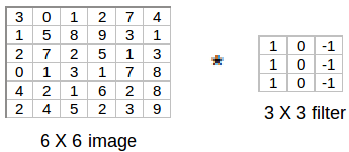

Results in: 


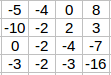

In [ ]:
X2=np.array([[3,0,1,2,7,4],[1,5,8,9,3,1],[2,7,2,5,1,3],[0,1,3,1,7,8],[4,2,1,6,2,8],[2,4,5,2,3,9]])
print(f"X2=\n{X2}")
kernel2 = np.array([[1,0,-1],[1,0,-1],[1,0,-1]])
print(f"kernel2=\n{kernel2}")


X2=
[[3 0 1 2 7 4]
 [1 5 8 9 3 1]
 [2 7 2 5 1 3]
 [0 1 3 1 7 8]
 [4 2 1 6 2 8]
 [2 4 5 2 3 9]]
kernel2=
[[ 1  0 -1]
 [ 1  0 -1]
 [ 1  0 -1]]


In [ ]:
def get_output_size(img_size: int, kernel_size: int, padding_size: int, stride_size: int) -> int:
    return ((img_size-kernel_size)+(2*padding_size))//stride_size + 1


def convolve_step(img: np.array, 
             kernel: np.array,
             padding_size: int,
             stride_size: int) -> np.array:

    # pad image
    pad_img = np.pad(img, padding_size, mode='constant')

    # Assuming a square image
    output_size = get_output_size(img_size=img.shape[0], kernel_size=kernel.shape[0], padding_size= padding_size, stride_size= stride_size)

    # To simplify things
    k = kernel.shape[0]
    
    # 2D array of zeros
    convolved_img = np.zeros(shape=(output_size, output_size))
    
    # Iterate over the rows
    for i in range(0, output_size):
        # Iterate over the columns
        for j in range(0, output_size):
            # img[i, j] = individual pixel value
            # Get the current matrix
            mat = pad_img[(i*stride_size):(i*stride_size)+k, (j*stride_size):(j*stride_size)+k]

            # Apply the convolution - element-wise multiplication and summation of the result
            # Store the result to i-th row and j-th column of our convolved_img array
            convolved_img[i, j] = np.sum(np.multiply(mat, kernel))

    return convolved_img


def pool2d(img: np.array, 
            kernel_size: int,
            padding_size: int,
            stride_size: int,
            pool_mode: str= 'max') -> np.array:

    # Padding
    pad_img = np.pad(img, padding_size, mode='constant')

    # Assuming a square image
    output_size = get_output_size(img_size=img.shape[0], kernel_size=kernel_size, padding_size= padding_size, stride_size= stride_size)

    # 2D array of zeros
    pool_img = np.zeros(shape=(output_size, output_size))
    
    # Iterate over the rows
    for i in range(0, output_size):
        # Iterate over the columns
        for j in range(0, output_size):
            # img[i, j] = individual pixel value
            # Get the current matrix
            mat = pad_img[(i*stride_size):(i*stride_size)+kernel_size, (j*stride_size):(j*stride_size)+kernel_size]

            # Apply the convolution - element-wise multiplication and summation of the result
            # Store the result to i-th row and j-th column of our convolved_img array
            pool_img[i, j] = mat.max() if pool_mode == "max" else mat.mean()

    return pool_img

In [ ]:
# ans
convolve_step(img= X1, 
             kernel= kernel1,
             padding_size=0,
             stride_size=1)

array([[ 16.,   9.,  -4., -18.],
       [ 17.,  -5., -10., -12.],
       [ 11.,  -9., -17.,   2.],
       [  9.,  -1., -15.,  16.]])

In [ ]:
# test
convolve_step(img= X2, 
             kernel= kernel2,
             padding_size=0,
             stride_size=1)

array([[ -5.,  -4.,   0.,   8.],
       [-10.,  -2.,   2.,   3.],
       [  0.,  -2.,  -4.,  -7.],
       [ -3.,  -2.,  -3., -16.]])

3. What is the output when you apply a max-pooling operation on the output from the previous question?

In [ ]:
# ans
img = convolve_step(img= X1, 
             kernel= kernel1,
             padding_size=0,
             stride_size=1)

pool2d(img= img, 
        kernel_size= 2,
        padding_size= 0,
        stride_size= 2,
        pool_mode= 'max')

array([[17., -4.],
       [11., 16.]])

In [ ]:
#test
img = convolve_step(img= X2, 
             kernel= kernel2,
             padding_size=0,
             stride_size=1)

pool2d(img= img, 
        kernel_size= 2,
        padding_size= 0,
        stride_size= 2,
        pool_mode= 'max')

array([[-2.,  8.],
       [ 0., -3.]])